In [1]:
import re
import time
import pickle
import numpy as np

from neural_decoder.neural_decoder_trainer_mamba import loadModel, getDatasetLoaders
from neural_decoder.model import GRUDecoder, MambaDecoder
from neural_decoder.dataset import SpeechDataset

from edit_distance import SequenceMatcher
import torch

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
trainingStats = pickle.load(open('/scratch/users/hdlee/speech_bci/logs/Mamba_Run2_speckled_masking_layerNorm_standardized_bidirectional_6layers/trainingStats', 'rb'))

In [3]:
trainingStats.keys()

dict_keys(['trainLoss', 'trainCER', 'testLoss', 'testCER'])

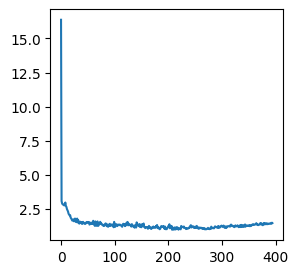

In [16]:
plt.figure(figsize=(3,3))
plt.plot(trainingStats['trainLoss'])
plt.show()

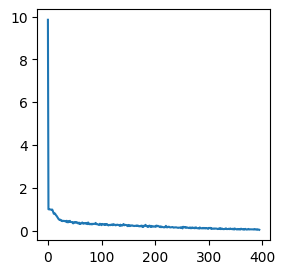

In [8]:
plt.figure(figsize=(3,3))
plt.plot(trainingStats['trainCER'])
plt.show()

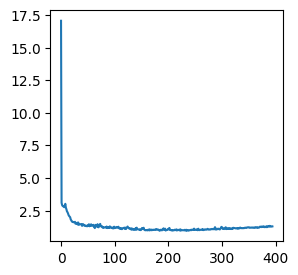

In [17]:
plt.figure(figsize=(3,3))
plt.plot(trainingStats['testLoss'])
plt.show()

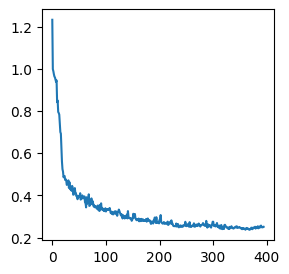

In [10]:
plt.figure(figsize=(3,3))
plt.plot(trainingStats['testCER'])
plt.show()

In [11]:
modelDir = '/scratch/users/hdlee/speech_bci/logs/Mamba_Run2_speckled_masking_layerNorm_standardized_bidirectional_6layers'
with open(modelDir + "/args", "rb") as handle:
    args = pickle.load(handle)

trainLoader, testLoader, loadedData = getDatasetLoaders(
    args["datasetPath"],
    args["batchSize"],
)

modelWeightPath = modelDir + "/modelWeights"
with open(modelDir + "/args", "rb") as handle:
    args = pickle.load(handle)

device = 'cuda'

model = MambaDecoder(
    neural_dim=args["nInputFeatures"],
    d_model=args["d_model"],
    d_state=args["d_state"],
    d_conv=args["d_conv"],
    expand_factor=args["expand_factor"],
    n_classes=args["nClasses"],
    layer_dim=args["nLayers"],
    nDays=len(loadedData["train"]),
    dropout=args["dropout"],
    device=device,
    strideLen=args["strideLen"],
    kernelLen=args["kernelLen"],
    gaussianSmoothWidth=args["gaussianSmoothWidth"],
    bidirectional=args["bidirectional"],
).to(device)

model.load_state_dict(torch.load(modelWeightPath, map_location=device))

model.eval()

MambaDecoder(
  (inputLayerNonlinearity): Softsign()
  (unfolder): Unfold(kernel_size=(1, 1), dilation=1, padding=0, stride=1)
  (layers): ModuleList(
    (0): Block(
      (mixer): BidirectionalMamba(
        (in_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (conv1d): Conv1d(1024, 1024, kernel_size=(4,), stride=(1,), padding=(3,), groups=1024)
        (act): SiLU()
        (x_proj): Linear(in_features=1024, out_features=192, bias=False)
        (dt_proj): Linear(in_features=64, out_features=1024, bias=True)
        (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
      )
      (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (1): Block(
      (mixer): BidirectionalMamba(
        (in_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (conv1d): Conv1d(1024, 1024, kernel_size=(4,), stride=(1,), padding=(3,), groups=1024)
        (act): SiLU()
        (x_proj): Linear(in_features=1024, out_features=192

In [18]:
mamba_outputs = {
    "logits": [],
    "logitLengths": [],
    "trueSeqs": [],
    "transcriptions": [],
}
partition = "competition"

In [19]:
for i, testDayIdx in tqdm(enumerate([4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20])):
    # for i, testDayIdx in enumerate(range(len(loadedData[partition]))):
    test_ds = SpeechDataset([loadedData[partition][i]])
    test_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=1, shuffle=False, num_workers=0
    )
    for j, (X, y, X_len, y_len, _) in enumerate(test_loader):
        X, y, X_len, y_len, dayIdx = (
            X.to(device),
            y.to(device),
            X_len.to(device),
            y_len.to(device),
            torch.tensor([testDayIdx], dtype=torch.int64).to(device),
        )
        pred = model.forward(X, dayIdx)
        adjustedLens = ((X_len - model.kernelLen) / model.strideLen).to(torch.int32)

        for iterIdx in range(pred.shape[0]):
            trueSeq = np.array(y[iterIdx][0 : y_len[iterIdx]].cpu().detach())

            mamba_outputs["logits"].append(pred[iterIdx].cpu().detach().numpy())
            mamba_outputs["logitLengths"].append(
                adjustedLens[iterIdx].cpu().detach().item()
            )
            mamba_outputs["trueSeqs"].append(trueSeq)

        transcript = loadedData[partition][i]["transcriptions"][j].strip()
        transcript = re.sub(r"[^a-zA-Z\- \']", "", transcript)
        transcript = transcript.replace("--", "").lower()
        mamba_outputs["transcriptions"].append(transcript)

15it [00:06,  2.22it/s]


In [20]:
pickle.dump(mamba_outputs, open(f'235_mamba_outputs_{partition}.pkl', 'wb'))